In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy
from tqdm import tqdm

In [2]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

In [3]:
import torch.optim as optim
from torch.utils import data

In [4]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, ActNorm2D, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

### Datasets

In [5]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [7]:
xx, yy = iter(train_loader).next()

In [8]:
xx.shape

torch.Size([128, 3, 32, 32])

### Model

In [31]:
actf = irf.Swish
flows = [
#     ActNorm2D(3),
    nn.BatchNorm2d(3),
    irf.ConvResidualFlow(3, [32, 32], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(12),
    nn.BatchNorm2d(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
#     ActNorm2D(12),
    nn.BatchNorm2d(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(48),
    nn.BatchNorm2d(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
#     ActNorm2D(48),
    nn.BatchNorm2d(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(192),
    nn.BatchNorm2d(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
#     ActNorm2D(192),
    nn.BatchNorm2d(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
    nn.BatchNorm2d(192),
    irf.Flatten(img_size=(192, 4, 4)),
#     ActNorm(3072),
    nn.BatchNorm1d(3072),
    nn.Linear(3072, 2),
#     ActNorm(2),
    nn.BatchNorm1d(2),
        ]

# backbone = SequentialFlow(flows)
backbone = nn.Sequential(*flows)

In [32]:
backbone.to(device)

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish()
      (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (2): InvertiblePooling()
  (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish()
      (4): Conv2d(64, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ConvResidualFlow(
    (resblock)

In [ ]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                nn.utils.remove_spectral_norm(child)
                print("Success")
            except:
                print("Failed")

In [ ]:
remove_spectral_normove_spectral_norm(backbone)

In [33]:
backbone(xx.to(device)).shape, 32*32*3

(torch.Size([128, 2]), 3072)

In [34]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))

number of params:  9953669


In [35]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                nn.utils.remove_spectral_norm(child)
                print("Success")
            except:
                print("Failed")
    return

In [36]:
# remove_spectral_norm(backbone)

In [37]:
for xx, yy in train_loader:
    tt = backbone(xx.to(device))
    print(xx.shape, tt.shape)
    break

torch.Size([128, 3, 32, 32]) torch.Size([128, 2])


In [38]:
class ConnectedClassifier_Linear(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.linear = nn.Linear(input_dim, num_sets)
#         self.linear.bias.data *= 0
#         self.linear.weight.data *= 0.1
#         self.cls_weight = nn.Parameter(torch.randn(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.1
        self.cls_weight = nn.Parameter(init_val)
        
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        x = self.linear(x)
        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [39]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.1
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized
#         return torch.softmax(x@self.cls_weight, dim=1)

    def set_centroid_to_data_randomly(self, data_loader, model):
        num_centers = self.centers.shape[0]
        xxs, yys = [], []
        count = 0
        for xx, yy in data_loader:
            yout = model(xx.to(device)).data.cpu()
            xxs.append(yout)
            yys.append(yy)
            count += len(xx)
            if count >= num_centers:
                break
        
        yout = torch.cat(xxs, dim=0)
        yy = torch.cat(yys, dim=0)
        
        yout = yout[:num_centers].to(self.centers.device)
        yy = yy[:num_centers].to(self.centers.device)
        
        self.centers.data = yout
        
        init_val = torch.ones(self.num_sets, self.output_dim)/self.output_dim
        for ns in range(num_centers):
            init_val[ns, yy[ns]] = 1.
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass

In [40]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../../../../_Datasets/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [41]:
train_loader.dataset.transforms

StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [42]:
classifier = ConnectedClassifier_SoftKMeans(2, 100, 10)
# classifier = ConnectedClassifier_Linear(2, 100, 10)
classifier = classifier.to(device)

In [43]:
classifier.set_centroid_to_data_randomly(train_loader, backbone)

In [44]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))
print("number of params: ", sum(p.numel() for p in classifier.parameters()))

number of params:  9953669
number of params:  1201


In [45]:
model = nn.Sequential(backbone, classifier).to(device)

In [46]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  9954870


## Training

In [48]:
# model_name = 'c10_2d_multi_inv_v0'
# model_name = 'c10_2d_multi_ord_v0'

In [49]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
#                       momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [50]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [51]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

In [52]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [53]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+200): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 0 Loss: 2.301 | Acc: 20.498 10249/50000


100%|██████████| 79/79 [00:03<00:00, 26.25it/s]


[Test] 0 Loss: 2.300 | Acc: 25.270 2527/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 1 Loss: 2.299 | Acc: 25.630 12815/50000


100%|██████████| 79/79 [00:03<00:00, 26.30it/s]


[Test] 1 Loss: 2.298 | Acc: 28.580 2858/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 2 Loss: 2.297 | Acc: 27.836 13918/50000


100%|██████████| 79/79 [00:03<00:00, 26.08it/s]


[Test] 2 Loss: 2.296 | Acc: 30.100 3010/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 3 Loss: 2.294 | Acc: 29.360 14680/50000


100%|██████████| 79/79 [00:03<00:00, 26.10it/s]


[Test] 3 Loss: 2.293 | Acc: 33.450 3345/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 4 Loss: 2.291 | Acc: 31.500 15750/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 4 Loss: 2.289 | Acc: 32.790 3279/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 5 Loss: 2.286 | Acc: 35.494 17747/50000


100%|██████████| 79/79 [00:03<00:00, 25.94it/s]


[Test] 5 Loss: 2.283 | Acc: 36.970 3697/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 6 Loss: 2.282 | Acc: 39.710 19855/50000


100%|██████████| 79/79 [00:03<00:00, 26.29it/s]


[Test] 6 Loss: 2.278 | Acc: 41.470 4147/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 7 Loss: 2.276 | Acc: 43.922 21961/50000


100%|██████████| 79/79 [00:03<00:00, 26.16it/s]


[Test] 7 Loss: 2.273 | Acc: 46.870 4687/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 8 Loss: 2.270 | Acc: 46.792 23396/50000


100%|██████████| 79/79 [00:03<00:00, 26.08it/s]


[Test] 8 Loss: 2.265 | Acc: 48.540 4854/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 9 Loss: 2.263 | Acc: 48.454 24227/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 9 Loss: 2.260 | Acc: 48.420 4842/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 10 Loss: 2.256 | Acc: 49.952 24976/50000


100%|██████████| 79/79 [00:03<00:00, 26.10it/s]


[Test] 10 Loss: 2.251 | Acc: 50.250 5025/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 11 Loss: 2.248 | Acc: 50.738 25369/50000


100%|██████████| 79/79 [00:03<00:00, 26.09it/s]


[Test] 11 Loss: 2.242 | Acc: 51.230 5123/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 12 Loss: 2.240 | Acc: 51.756 25878/50000


100%|██████████| 79/79 [00:03<00:00, 26.26it/s]


[Test] 12 Loss: 2.234 | Acc: 53.460 5346/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 13 Loss: 2.231 | Acc: 52.148 26074/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 13 Loss: 2.226 | Acc: 50.370 5037/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 14 Loss: 2.221 | Acc: 52.982 26491/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 14 Loss: 2.217 | Acc: 52.100 5210/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 15 Loss: 2.211 | Acc: 53.258 26629/50000


100%|██████████| 79/79 [00:03<00:00, 26.16it/s]


[Test] 15 Loss: 2.204 | Acc: 53.770 5377/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 16 Loss: 2.201 | Acc: 53.928 26964/50000


100%|██████████| 79/79 [00:03<00:00, 26.20it/s]


[Test] 16 Loss: 2.194 | Acc: 54.110 5411/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 17 Loss: 2.190 | Acc: 54.626 27313/50000


100%|██████████| 79/79 [00:03<00:00, 26.16it/s]


[Test] 17 Loss: 2.181 | Acc: 54.570 5457/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 18 Loss: 2.180 | Acc: 54.776 27388/50000


100%|██████████| 79/79 [00:03<00:00, 26.11it/s]


[Test] 18 Loss: 2.170 | Acc: 55.890 5589/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 19 Loss: 2.168 | Acc: 55.738 27869/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 19 Loss: 2.162 | Acc: 54.460 5446/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 20 Loss: 2.156 | Acc: 56.228 28114/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 20 Loss: 2.148 | Acc: 55.730 5573/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 21 Loss: 2.145 | Acc: 57.310 28655/50000


100%|██████████| 79/79 [00:03<00:00, 25.99it/s]


[Test] 21 Loss: 2.145 | Acc: 58.070 5807/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 22 Loss: 2.133 | Acc: 58.734 29367/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 22 Loss: 2.127 | Acc: 57.640 5764/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 23 Loss: 2.122 | Acc: 59.870 29935/50000


100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


[Test] 23 Loss: 2.114 | Acc: 61.530 6153/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 24 Loss: 2.110 | Acc: 60.902 30451/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 24 Loss: 2.104 | Acc: 60.230 6023/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 25 Loss: 2.098 | Acc: 61.574 30787/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 25 Loss: 2.096 | Acc: 60.480 6048/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 26 Loss: 2.086 | Acc: 62.354 31177/50000


100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


[Test] 26 Loss: 2.076 | Acc: 63.210 6321/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 27 Loss: 2.075 | Acc: 62.984 31492/50000


100%|██████████| 79/79 [00:06<00:00, 12.61it/s]


[Test] 27 Loss: 2.065 | Acc: 63.350 6335/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 28 Loss: 2.063 | Acc: 63.566 31783/50000


100%|██████████| 79/79 [00:06<00:00, 12.66it/s]


[Test] 28 Loss: 2.056 | Acc: 63.660 6366/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 29 Loss: 2.051 | Acc: 64.266 32133/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 29 Loss: 2.046 | Acc: 63.530 6353/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 30 Loss: 2.039 | Acc: 64.822 32411/50000


100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


[Test] 30 Loss: 2.034 | Acc: 64.150 6415/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 31 Loss: 2.027 | Acc: 64.764 32382/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 31 Loss: 2.023 | Acc: 64.060 6406/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 32 Loss: 2.015 | Acc: 65.246 32623/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 32 Loss: 2.017 | Acc: 63.630 6363/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 33 Loss: 2.005 | Acc: 65.452 32726/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 33 Loss: 2.002 | Acc: 64.140 6414/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 34 Loss: 1.992 | Acc: 66.034 33017/50000


100%|██████████| 79/79 [00:06<00:00, 12.63it/s]


[Test] 34 Loss: 1.987 | Acc: 65.490 6549/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 35 Loss: 1.980 | Acc: 66.244 33122/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 35 Loss: 1.978 | Acc: 64.990 6499/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 36 Loss: 1.969 | Acc: 66.922 33461/50000


100%|██████████| 79/79 [00:06<00:00, 12.67it/s]


[Test] 36 Loss: 1.968 | Acc: 65.740 6574/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 37 Loss: 1.959 | Acc: 67.764 33882/50000


100%|██████████| 79/79 [00:06<00:00, 12.55it/s]


[Test] 37 Loss: 1.954 | Acc: 67.320 6732/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 38 Loss: 1.948 | Acc: 68.888 34444/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 38 Loss: 1.946 | Acc: 66.350 6635/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 39 Loss: 1.938 | Acc: 69.694 34847/50000


100%|██████████| 79/79 [00:06<00:00, 12.63it/s]


[Test] 39 Loss: 1.931 | Acc: 71.140 7114/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 40 Loss: 1.928 | Acc: 70.300 35150/50000


100%|██████████| 79/79 [00:06<00:00, 12.62it/s]


[Test] 40 Loss: 1.923 | Acc: 71.630 7163/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 41 Loss: 1.917 | Acc: 71.338 35669/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 41 Loss: 1.917 | Acc: 70.980 7098/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 42 Loss: 1.907 | Acc: 72.098 36049/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 42 Loss: 1.915 | Acc: 70.210 7021/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 43 Loss: 1.899 | Acc: 72.412 36206/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 43 Loss: 1.898 | Acc: 71.250 7125/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 44 Loss: 1.891 | Acc: 73.080 36540/50000


100%|██████████| 79/79 [00:06<00:00, 12.69it/s]


[Test] 44 Loss: 1.888 | Acc: 72.620 7262/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 45 Loss: 1.880 | Acc: 73.684 36842/50000


100%|██████████| 79/79 [00:05<00:00, 13.56it/s]


[Test] 45 Loss: 1.884 | Acc: 73.740 7374/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 46 Loss: 1.872 | Acc: 74.472 37236/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 46 Loss: 1.876 | Acc: 72.740 7274/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 47 Loss: 1.862 | Acc: 75.006 37503/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 47 Loss: 1.867 | Acc: 73.690 7369/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 48 Loss: 1.856 | Acc: 75.480 37740/50000


100%|██████████| 79/79 [00:06<00:00, 12.60it/s]


[Test] 48 Loss: 1.858 | Acc: 74.040 7404/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 49 Loss: 1.848 | Acc: 75.740 37870/50000


100%|██████████| 79/79 [00:06<00:00, 12.65it/s]


[Test] 49 Loss: 1.851 | Acc: 74.950 7495/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 50 Loss: 1.838 | Acc: 76.484 38242/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 50 Loss: 1.846 | Acc: 74.010 7401/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 51 Loss: 1.830 | Acc: 76.720 38360/50000


100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


[Test] 51 Loss: 1.832 | Acc: 75.810 7581/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 52 Loss: 1.824 | Acc: 76.886 38443/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 52 Loss: 1.833 | Acc: 74.270 7427/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 53 Loss: 1.813 | Acc: 77.642 38821/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 53 Loss: 1.823 | Acc: 75.420 7542/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 54 Loss: 1.806 | Acc: 77.804 38902/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 54 Loss: 1.819 | Acc: 74.630 7463/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 55 Loss: 1.799 | Acc: 78.054 39027/50000


100%|██████████| 79/79 [00:06<00:00, 12.68it/s]


[Test] 55 Loss: 1.803 | Acc: 76.340 7634/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 56 Loss: 1.791 | Acc: 78.340 39170/50000


100%|██████████| 79/79 [00:06<00:00, 12.72it/s]


[Test] 56 Loss: 1.796 | Acc: 77.050 7705/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 57 Loss: 1.785 | Acc: 78.594 39297/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 57 Loss: 1.791 | Acc: 76.860 7686/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 58 Loss: 1.774 | Acc: 79.198 39599/50000


100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


[Test] 58 Loss: 1.785 | Acc: 77.290 7729/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 59 Loss: 1.768 | Acc: 79.592 39796/50000


100%|██████████| 79/79 [00:06<00:00, 12.56it/s]


[Test] 59 Loss: 1.777 | Acc: 77.440 7744/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 60 Loss: 1.764 | Acc: 79.300 39650/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 60 Loss: 1.774 | Acc: 77.200 7720/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 61 Loss: 1.757 | Acc: 79.682 39841/50000


100%|██████████| 79/79 [00:06<00:00, 12.67it/s]


[Test] 61 Loss: 1.767 | Acc: 77.810 7781/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 62 Loss: 1.751 | Acc: 80.060 40030/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 62 Loss: 1.768 | Acc: 77.100 7710/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 63 Loss: 1.747 | Acc: 80.042 40021/50000


100%|██████████| 79/79 [00:06<00:00, 12.60it/s]


[Test] 63 Loss: 1.759 | Acc: 78.050 7805/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 64 Loss: 1.742 | Acc: 80.216 40108/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 64 Loss: 1.758 | Acc: 77.530 7753/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 65 Loss: 1.735 | Acc: 80.508 40254/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 65 Loss: 1.750 | Acc: 77.940 7794/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 66 Loss: 1.729 | Acc: 80.816 40408/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 66 Loss: 1.753 | Acc: 77.300 7730/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 67 Loss: 1.727 | Acc: 80.602 40301/50000


100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


[Test] 67 Loss: 1.741 | Acc: 78.290 7829/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 68 Loss: 1.721 | Acc: 80.852 40426/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 68 Loss: 1.745 | Acc: 77.420 7742/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 70 Loss: 1.713 | Acc: 81.160 40580/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 70 Loss: 1.745 | Acc: 77.050 7705/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 71 Loss: 1.709 | Acc: 81.302 40651/50000


100%|██████████| 79/79 [00:05<00:00, 13.71it/s]


[Test] 71 Loss: 1.722 | Acc: 79.330 7933/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 72 Loss: 1.703 | Acc: 81.794 40897/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 72 Loss: 1.720 | Acc: 79.170 7917/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 73 Loss: 1.698 | Acc: 81.888 40944/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 73 Loss: 1.724 | Acc: 78.540 7854/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 74 Loss: 1.697 | Acc: 81.810 40905/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 74 Loss: 1.725 | Acc: 78.200 7820/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 75 Loss: 1.691 | Acc: 82.136 41068/50000


100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


[Test] 75 Loss: 1.710 | Acc: 79.680 7968/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 76 Loss: 1.688 | Acc: 82.374 41187/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 76 Loss: 1.714 | Acc: 78.900 7890/10000


  6%|▌         | 22/391 [00:05<01:26,  4.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 110 Loss: 1.616 | Acc: 86.128 43064/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 110 Loss: 1.655 | Acc: 81.880 8188/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 111 Loss: 1.620 | Acc: 85.660 42830/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 111 Loss: 1.654 | Acc: 81.900 8190/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 112 Loss: 1.614 | Acc: 86.264 43132/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 112 Loss: 1.654 | Acc: 81.780 8178/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 113 Loss: 1.612 | Acc: 86.392 43196/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 113 Loss: 1.652 | Acc: 81.900 8190/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 114 Loss: 1.611 | Acc: 86.476 43238/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 114 Loss: 1.663 | Acc: 81.040 8104/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 115 Loss: 1.613 | Acc: 86.268 43134/50000


100%|██████████| 79/79 [00:06<00:00, 12.68it/s]


[Test] 115 Loss: 1.652 | Acc: 82.060 8206/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 116 Loss: 1.611 | Acc: 86.360 43180/50000


100%|██████████| 79/79 [00:06<00:00, 12.69it/s]


[Test] 116 Loss: 1.648 | Acc: 82.410 8241/10000
Saving..


 65%|██████▍   | 253/391 [00:58<00:32,  4.31it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 150 Loss: 1.578 | Acc: 89.154 44577/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 150 Loss: 1.631 | Acc: 83.640 8364/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 151 Loss: 1.578 | Acc: 89.108 44554/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 151 Loss: 1.634 | Acc: 83.430 8343/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 152 Loss: 1.576 | Acc: 89.284 44642/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 152 Loss: 1.633 | Acc: 83.460 8346/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 153 Loss: 1.574 | Acc: 89.456 44728/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 153 Loss: 1.633 | Acc: 83.430 8343/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 154 Loss: 1.576 | Acc: 89.316 44658/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 154 Loss: 1.632 | Acc: 83.490 8349/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 155 Loss: 1.573 | Acc: 89.530 44765/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 155 Loss: 1.632 | Acc: 83.460 8346/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 156 Loss: 1.576 | Acc: 89.252 44626/50000


100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


[Test] 156 Loss: 1.630 | Acc: 83.770 8377/10000
Saving..


 82%|████████▏ | 321/391 [01:14<00:16,  4.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 188 Loss: 1.629 | Acc: 83.700 8370/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 189 Loss: 1.564 | Acc: 90.454 45227/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 189 Loss: 1.629 | Acc: 83.670 8367/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 190 Loss: 1.563 | Acc: 90.528 45264/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 190 Loss: 1.630 | Acc: 83.600 8360/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 191 Loss: 1.564 | Acc: 90.372 45186/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 191 Loss: 1.630 | Acc: 83.620 8362/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 192 Loss: 1.565 | Acc: 90.280 45140/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 192 Loss: 1.629 | Acc: 83.700 8370/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 193 Loss: 1.565 | Acc: 90.328 45164/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 193 Loss: 1.630 | Acc: 83.640 8364/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 194 Loss: 1.567 | Acc: 90.130 45065/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 194 Loss: 1.629 | Acc: 83.750 8375/10000


 96%|█████████▌| 376/391 [01:27<00:03,  4.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [54]:
best_acc

83.89

In [55]:
'''
actf = irf.Swish
flows = [
    ActNorm2D(3),
    irf.ConvResidualFlow(3, [32, 32], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
    ActNorm2D(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
    ActNorm2D(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
    ActNorm2D(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
    irf.Flatten(img_size=(192, 4, 4)),
    ActNorm(3072),
    nn.Linear(3072, 2),
    ActNorm(2),
        ]
'''
### ACC: 80.45 --> Inv + Connected Linear
### ACC:  --> Ord + Connected Linear

'''
actf = irf.Swish
flows = [
    nn.BatchNorm2d(3),
    irf.ConvResidualFlow(3, [32, 32], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    nn.BatchNorm2d(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
    nn.BatchNorm2d(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    nn.BatchNorm2d(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
    nn.BatchNorm2d(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    nn.BatchNorm2d(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
    nn.BatchNorm2d(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
    nn.BatchNorm2d(192),
    irf.Flatten(img_size=(192, 4, 4)),
    nn.BatchNorm1d(3072),
    nn.Linear(3072, 2),
    nn.BatchNorm1d(2),
        ]
'''
### ACC: 83.750 --> Inv + Connected Linear
### ACC:  --> Ord + Connected Linear

print()

In [56]:
classifier.inv_temp

Parameter containing:
tensor([4.9626], device='cuda:1', requires_grad=True)

In [57]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(83.89, 179)

### Hard test accuracy with count per classifier

In [58]:
model.eval()
print("Testing")

Testing


In [59]:
backbone, classifier = model[0], model[1]

In [60]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Test Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████| 79/79 [00:06<00:00, 13.08it/s]

Hard Test Acc:83.84%
[519, 724, 0, 0, 0, 0, 12, 0, 13, 2, 0, 6, 60, 132, 0, 40, 95, 6, 2, 1, 12, 4, 0, 104, 3, 0, 19, 3, 1, 5, 1, 0, 0, 0, 107, 1, 1, 486, 0, 7, 4, 0, 0, 27, 0, 113, 910, 0, 0, 0, 0, 972, 4, 99, 4, 14, 0, 635, 1, 842, 2, 2, 184, 22, 16, 17, 957, 58, 6, 0, 16, 9, 104, 14, 0, 23, 14, 1, 0, 7, 11, 0, 24, 977, 0, 22, 0, 11, 4, 2, 0, 9, 7, 146, 7, 769, 14, 553, 0, 1]


In [61]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(71, device='cuda:1')

In [62]:
embeddings, labels, ilabels = [], [], []
model.eval()
for xx, yy in tqdm(test_loader):
    ilabels.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        embs = backbone(xx)
        embeddings.append(embs.cpu())
        
        yout = classifier(embs, hard=True)
        labels.append(torch.argmax(yout, dim=1).cpu())

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)
ilabels = torch.cat(ilabels, dim=0)

100%|██████████| 79/79 [00:06<00:00, 13.14it/s]


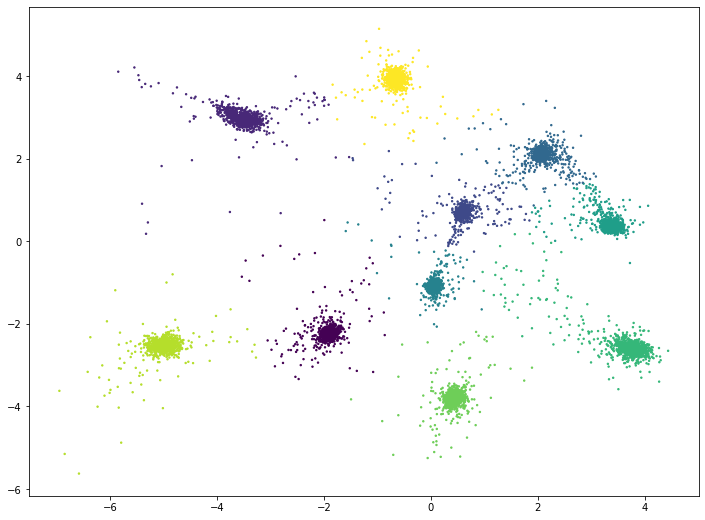

In [71]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=labels, s=2)
plt.savefig('./output/01_prediction_c10.pdf')

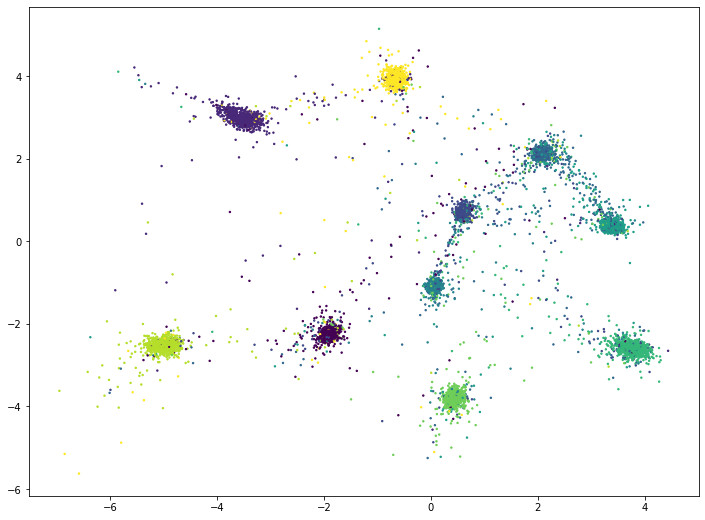

In [72]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2)
plt.savefig('./output/02_ground_truth_c10.pdf')

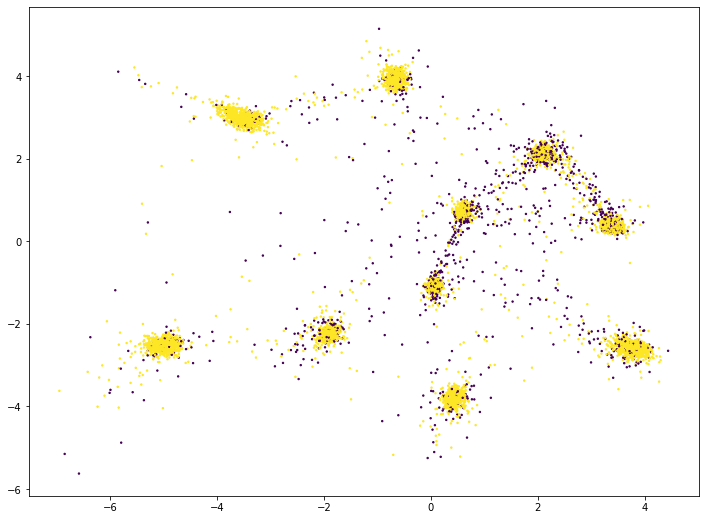

In [73]:
### Error Nodes
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=(labels==ilabels), s=2)
plt.savefig('./output/03_errors_c10.pdf')

### plot on a 2D map, the decision boundary

In [74]:
ng = 1000
_a,_b,_c,_d = embeddings[:,0].min()-0.1, embeddings[:,0].max()+0.1, embeddings[:,1].min()-0.1, embeddings[:,1].max()+0.1
xg, yg = torch.linspace(_a, _b, ng), torch.linspace(_c, _d, ng)
xg, yg = torch.meshgrid(xg, yg)
xyg = torch.stack([xg.reshape(-1), yg.reshape(-1)], dim=-1)

In [75]:
BS = 1000
output = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier(xx, hard=True)
        output.append(torch.argmax(yout, dim=1).cpu())
        
output = torch.cat(output, dim=0)

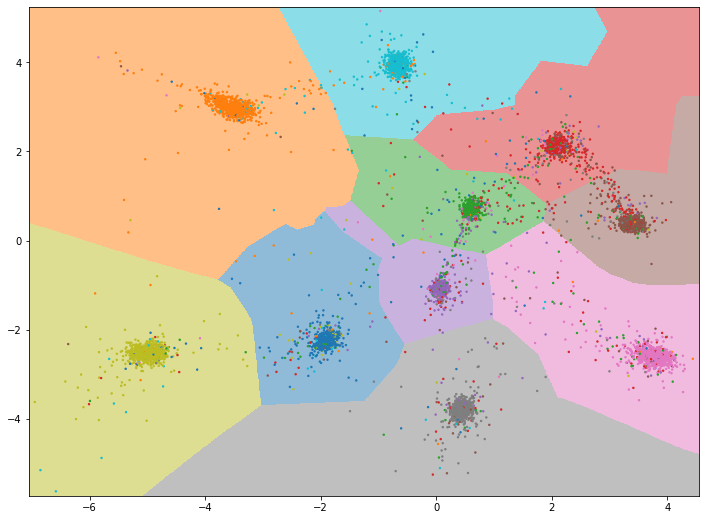

In [76]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

plt.savefig('./output/04_DecisionBoundary_Class_c10.pdf')

In [77]:
## display different class boundary
BS = 1000
output2 = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier(xx, hard=True)
        output2.append(torch.argmax(classifier.cls_confidence, dim=1).cpu())
output2 = torch.cat(output2, dim=0)

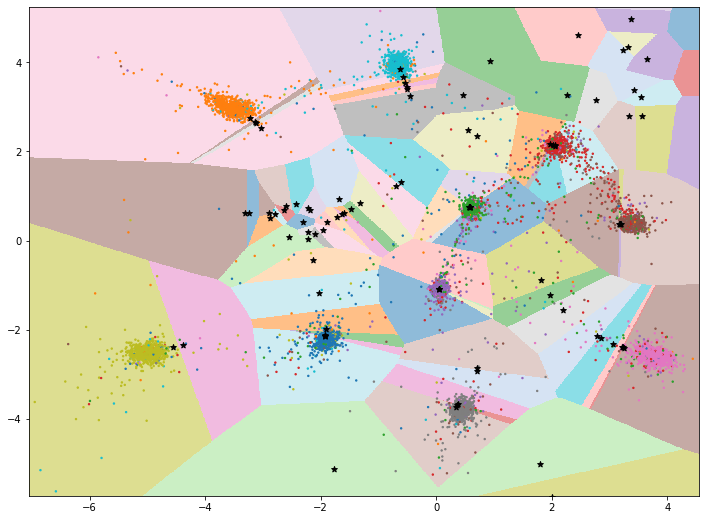

In [79]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab20',
           aspect='auto', origin='lower')
### plot centroids as well
plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')
plt.xlim(xg.min(), xg.max())
plt.ylim(yg.min(), yg.max()) 
plt.savefig('./output/05_DecisionBoundary_Sets_c10.pdf')

### Hard train accuracy with count per classifier

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

In [ ]:
#### classifier with class representation
torch.argmax(classifier.cls_weight, dim=1)

### analyze per classifier accuracy

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
# set_acc/set_count

In [ ]:
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t {cnt},\t {cls}\t {acc*100:.2f}%")